In [1]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.optimize import curve_fit
from concurrent.futures import ProcessPoolExecutor, as_completed

from src.solvers import solve_lorenz
from src.models import Models as mod
from src.utils.metrics import Metrics as m
from src.utils.lyapunov import Lyapunov as ly
from src.utils.sampler import sample_trajectory
from src.utils.generators import generate_pairs_of_initial_states

# Predicting Chaos from Timeseries

**Author:** Kristóf Benedek

**Information:** Please find all the related code figuresand some of the saved result in this [GitHub repo](https://github.com/BKris2315/predicting-chaos-from-timeseries)

## Introduvtion
This project was made as the final assignment for the [Classical and Quantum Chaos](https://physics.bme.hu/BMETE15AF45_kov?language=en) course at the Budapest University of Technology and Economics (BME). 

The project aims to verify and implement in python the proposed 0-1 test for chaos in classical systems by Wernecke et al [1]

For a chaotic system pairs of initially close-by trajectories become eventually fully uncorrelated on the attracting set. This
process of decorrelation may split into an initial exponential decrease, characterized by the maximal Lyapunov exponent, and a
subsequent diffusive process on the chaotic attractor causing the final loss of predictability. 

Tests for distinguishing chaos from laminar flow widely use the time evolution of inter-orbital correlations as an indicator.
Standard tests however yield mostly ambiguous results when it comes to distinguish partially predictable chaos and laminar
flow, which are characterized respectively by attractors of fractally broadened braids and limit cycles.

Let's intorduce two concepts:

- **Partially predictable chaos**: A chaotic system where the time evolution of inter-orbital correlations is not perfectly correlated, but still decreases exponentially with time. The first decorrelation occurring on a time scale of $T_\lambda$ does not destroy, in this case, all pair-wise correlations. The cross-correlation $C_{12}$ will retain a finite value even for $t \gg T_\lambda$, vanishing only for exceedingly long times.
- **Strong Chaos:** Predictability vanishes, approaching zero on a time scale of $T_\lambda$
The system we anal;yze can be defined as follows:

[1] Wernecke, H., Sándor, B., & Gros, C. (2017). How to test for partially predictable chaos. *Scientific Reports, 7*(1), 1087. https://doi.org/10.1038/s41598-017-01083-x

## The Lorentz system overview

Defining the system

Consider $x = (x, y,z)$:

$$ 
\begin{gather*}
\dot{x} = \sigma(y - x)\\ 
\dot{y} = x(\rho - z) - y \\ 
\dot{z} = xy - \beta z
\end{gather*}
$$

the Lorenz system, which has long been used for studying the interplay between predictability and chaos. We select with $\beta = 8/3$ and $\sigma = 10$ standard parameter settings, retaining $\rho$ as the bifurcation parameter.

![](lorenz_attractor.gif)

In [26]:
# Parameters
dr = 0.003125
r_values = np.arange(180, 183, dr)
dt = 0.001
t_span = (0, 150)
# Initial state
initial_state = np.array([1.0, 1.0, 1.0], dtype=np.float64)

# Solve the system
res = solve_lorenz(r_values, t_span, dt, initial_state, if_ode = True, method = 'LSODA')


100%|██████████| 960/960 [02:37<00:00,  6.10it/s]


In [27]:
vals_list = []
control_param_list = []
save_bif = 0

for i, r in enumerate(r_values):
    cpl, vl = m.poincare_section(
        trajectory=res['trajectories'][i],
        control_param=r,
        dim=2,
        mode="min"
    )
    vals_list.extend(vl)
    control_param_list.extend(cpl)

if save_bif:
    np.savetxt("../outputs/bif_z_min.dat", np.vstack((control_param_list, vals_list)).T)



Visualizing the Lorenz attractor for $\rho=183$ value.

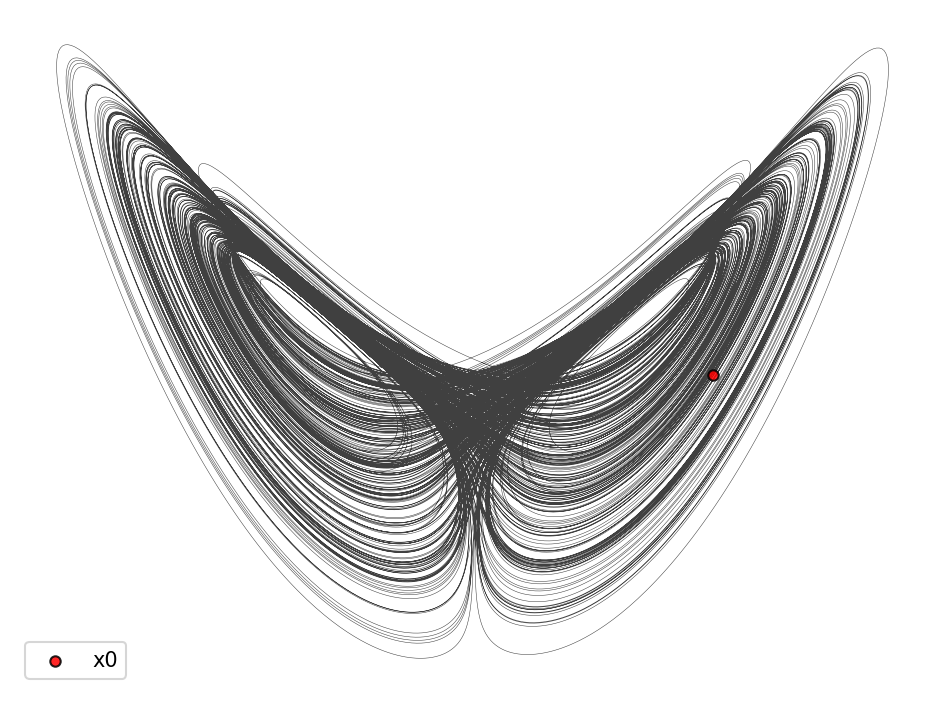

In [28]:
fig, ax = plt.subplots(1,dpi=150)
ax.plot(res['trajectories'][i][:,0], res['trajectories'][i][:,2], lw = .25, c = "k", alpha = .75)
ax.scatter(res['trajectories'][i][0,0], res['trajectories'][i][0,2], c ='r', ec = 'k', s = 25, zorder = 10, label = "x0", alpha = .85)
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.axis("off")
plt.legend()
plt.tight_layout()
plt.savefig('../figs/nice_lorenz_butterfly.png', dpi = 150)
plt.show()

Tjhe bifurcation diagram of the Lorenz system over a wide range of $\rho$ values. We can identify three distinct regimes:
1. Strong Chaos
2. Partially Predictable Chaos (PPC)
3. Laminar/regular flow

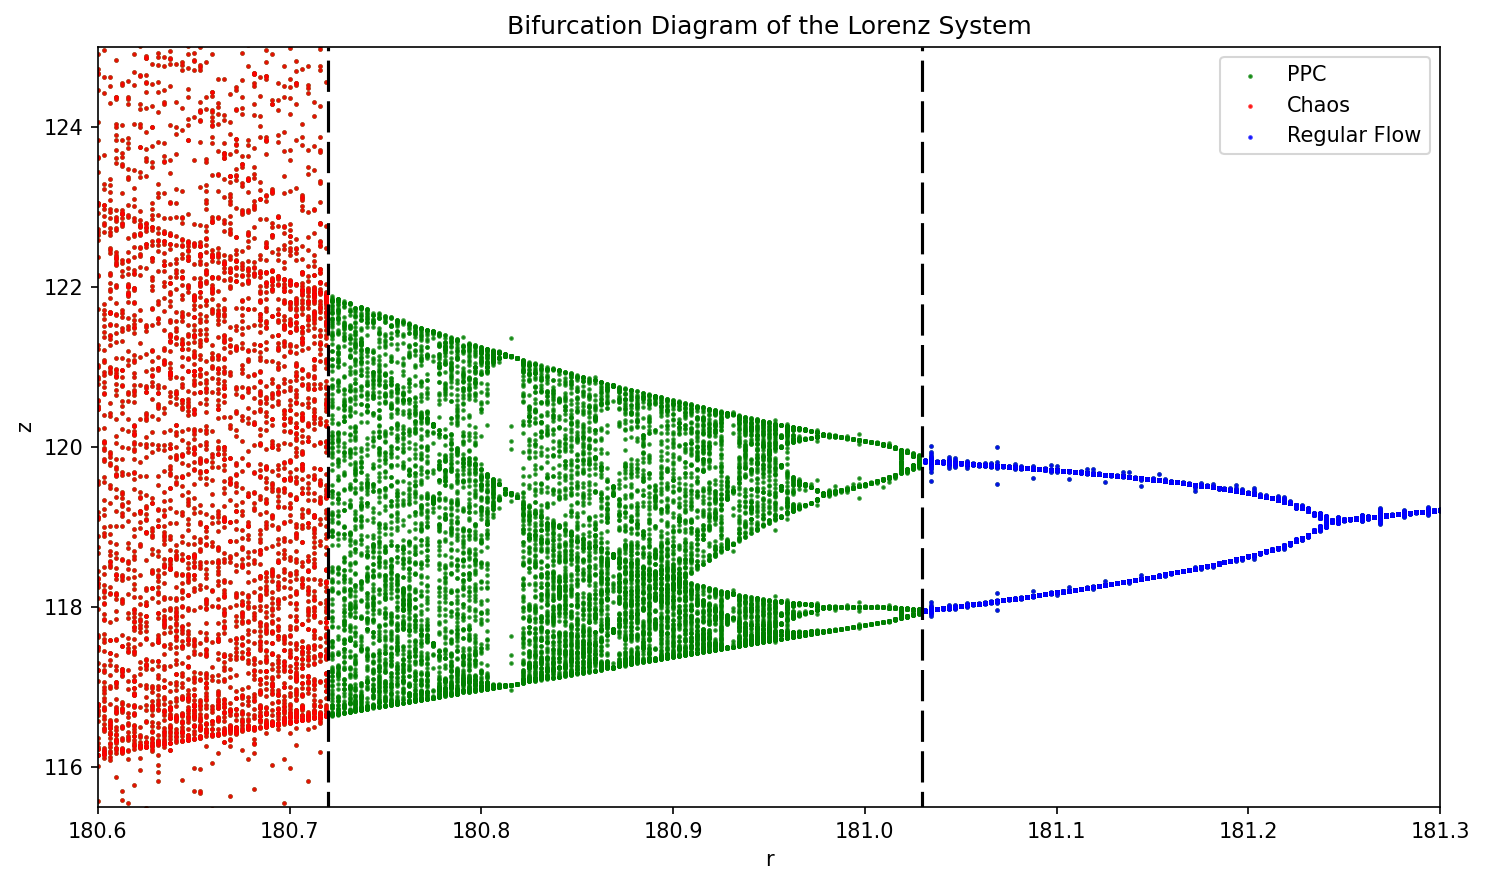

In [29]:
# Plot the results
load_bif = 1

if load_bif:
    control_param_list, vals_list = np.loadtxt("../outputs/bif_z_min.dat", unpack=True)
plt.figure(figsize=(10, 6), dpi=150)

mask1 = control_param_list <= 180.72
mask2 = control_param_list >= 181.03
plt.scatter(control_param_list, vals_list, color='green', s=1.5, label='PPC', alpha = 0.75)
plt.scatter(control_param_list[mask1], vals_list[mask1], color='red', s=1.5, label='Chaos', alpha = 0.75)
plt.scatter(control_param_list[mask2], vals_list[mask2], color='blue', s=1.5, label='Regular Flow', alpha = 0.75)
plt.axvline(x=181.03, color='k', ls = (5, (10, 3)))
plt.axvline(x=180.72, color='k', ls = (5, (10, 3)))

plt.xlabel('r')
plt.ylabel('z')
plt.title('Bifurcation Diagram of the Lorenz System')
plt.legend()
plt.xlim(180.6, 181.3)
plt.ylim(115.5,125)
plt.tight_layout()
plt.savefig("../figs/bif_diagram.png", dpi = 150)
plt.show()

In [4]:
# Parameters
r_values_spec = (180.7, 180.78, 181.03, 181.15)
dt = 0.001
t_span = (0, 150)
# Initial state
initial_state = np.array([1.0, 1.0, 1.0], dtype=np.float64)

# Solve the system
res = solve_lorenz(r_values_spec, t_span, dt, initial_state, if_ode = True, method = 'LSODA')


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Sample trajectories of the Lorenz system projected to the $x−z$ plane. The phases, from left to right, display ergodic motion, the second and third figures show PPC, and the last is alimit cycle (cf. the bifurcation diagram above)

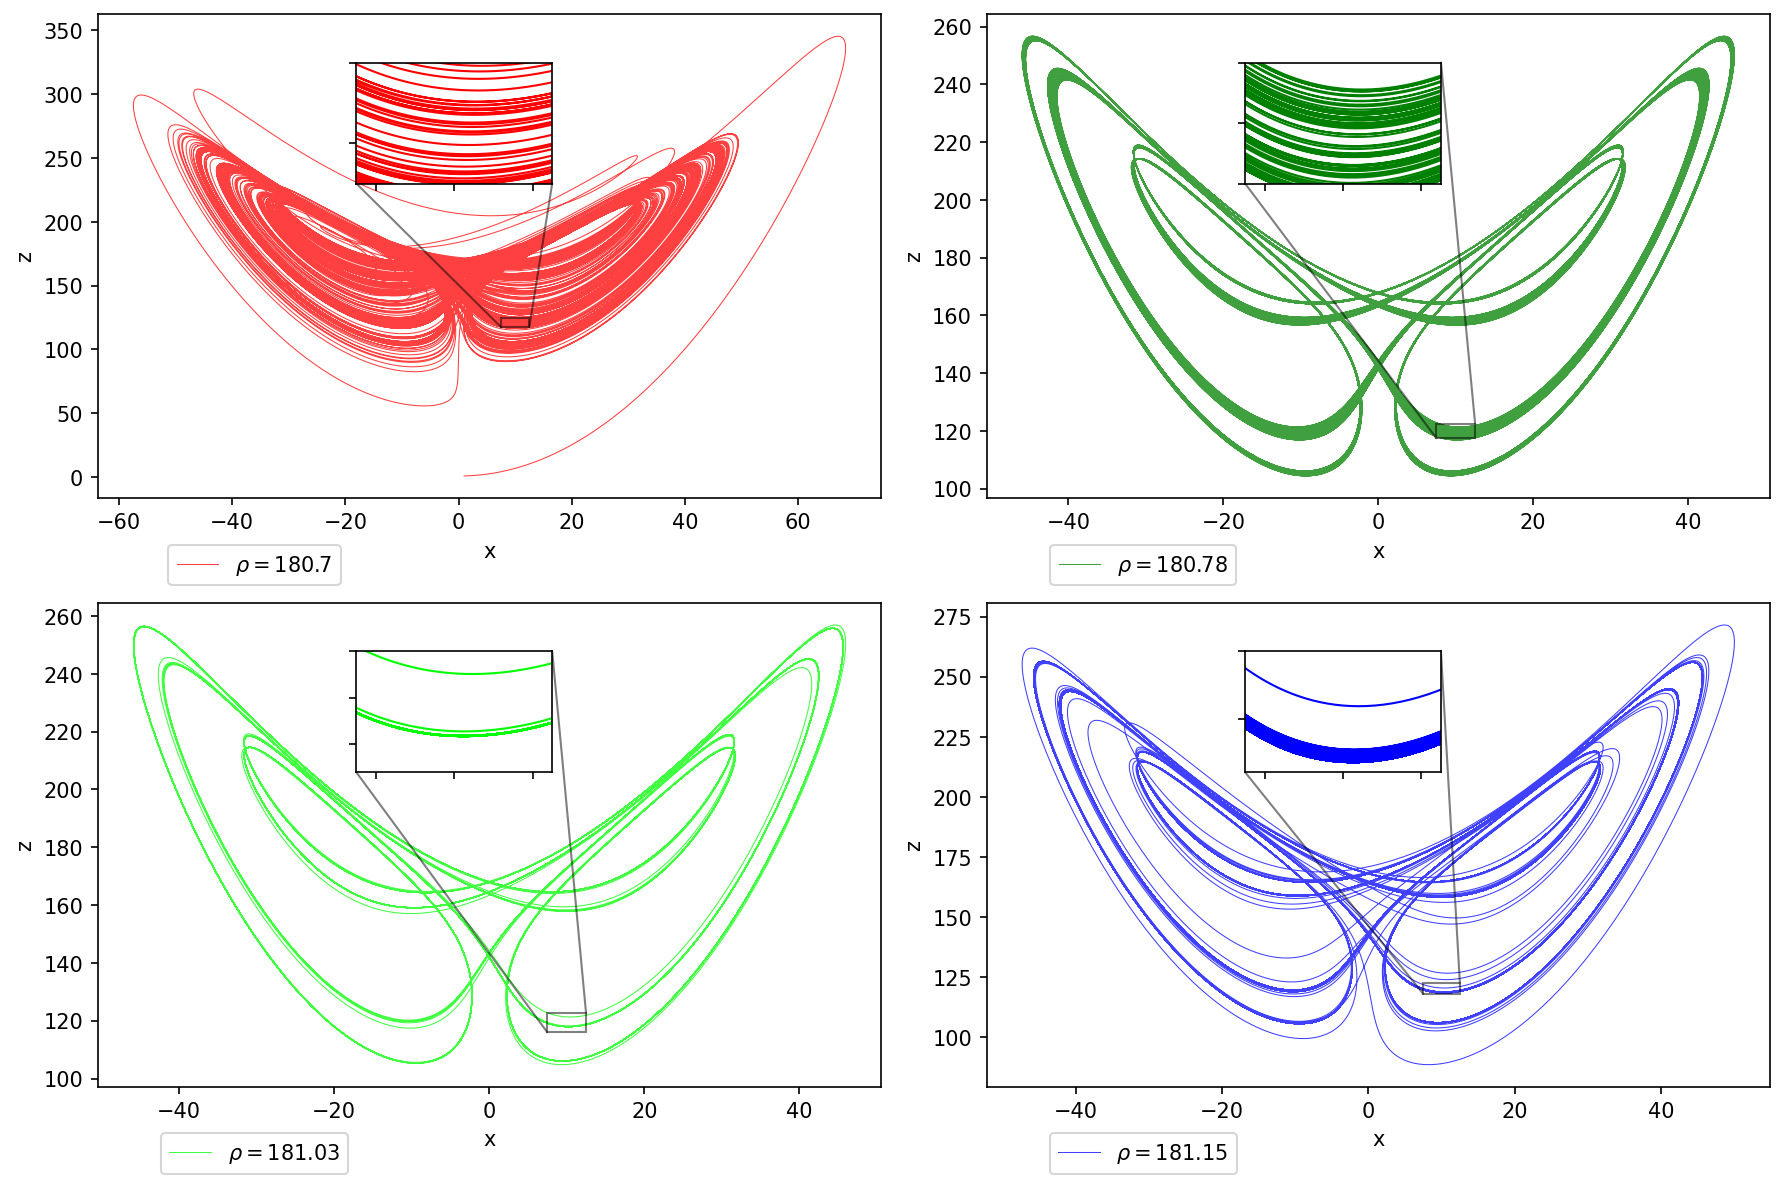

In [31]:
fig, ax = plt.subplots(2,2, figsize = (12,8), dpi=150)
ax = ax.flatten()

colors = ['r', 'g', 'lime', 'b']

x1s = [7.5, 7.5, 7.5, 7.5]
x2s = [12.5, 12.5, 12.5, 12.5]
y1s = [117.5,117.5, 116., 118]
y2s = [125,122.5, 122.5, 122.5]

for i in range(4):
    ax[i].plot(res['trajectories'][i][:,0], res['trajectories'][i][:,2], lw = .5, c = colors[i], alpha = .75, label= rf'$\rho={{{r_values_spec[i]}}}$')
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("z")
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.2, -0.075),
          fancybox=True, ncol=1)

    axins = ax[i].inset_axes([0.33, 0.65, 0.25, 0.25], xlim=(x1s[i], x2s[i]), ylim=(y1s[i], y2s[i]), xticklabels=[], yticklabels=[])
    axins.plot(res['trajectories'][i][:,0], res['trajectories'][i][:,2], c = colors[i], lw = 1)
    ax[i].indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()
plt.savefig("../figs/lorenz_attractor_zoom.png", dpi = 150)
plt.show()

In [3]:
delta_dist = 1e-8
pairs_with_d4 = generate_pairs_of_initial_states(5, delta_dist)

# Parameters
dr = 0.003125
r_values = np.arange(180.6, 181.3, dr)
dt = 0.001
t_span = (0, 250)

# Function to solve for a single initial state
def solve_single_lorenz(initial_state):
    return solve_lorenz(r_values, t_span, dt, initial_state, if_ode=True, method='LSODA', init_update=True)

###############
#   WARNING   #
###############
# This code block munches on RAM and CPU. 
# It was ran with this parametrization on a 16-core machine with 50GB of RAM.

# Parallel execution
results = []
with ProcessPoolExecutor() as executor:
    # Submit tasks for solving res1 and res2 independently
    future_to_pair_index = {}
    for i in range(pairs_with_d4[0].shape[0]):
        initial_state1 = pairs_with_d4[0][i]
        initial_state2 = pairs_with_d4[1][i]
        # Submit tasks for both res1 and res2
        future1 = executor.submit(solve_single_lorenz, initial_state1)
        future2 = executor.submit(solve_single_lorenz, initial_state2)
        future_to_pair_index[future1] = (i, 1)  # Track pair index and result type (1 for res1)
        future_to_pair_index[future2] = (i, 2)  # Track pair index and result type (2 for res2)
    
    # Collect results as they complete
    result_dict = {i: [None, None] for i in range(pairs_with_d4[0].shape[0])}  # Placeholder for results
    for future in as_completed(future_to_pair_index):
        i, res_type = future_to_pair_index[future]
        if res_type == 1:
            result_dict[i][0] = future.result()  # Store res1
        elif res_type == 2:
            result_dict[i][1] = future.result()  # Store res2

100%|██████████| 225/225 [01:36<00:00,  2.34it/s]


In [4]:
# Parameters
delta_dist = 1e-4
pairs_with_d4 = generate_pairs_of_initial_states(5, delta_dist)
dr = 0.003125
r_values = np.arange(180.6, 181.3, dr)
dt = 0.001
t_span = (0, 500)
t_eval = np.arange(t_span[0], t_span[1],dt)

In [ ]:
###############
#   WARNING   #
###############
# This code block munches on RAM and CPU. 
# It was ran with this parametrization on a 16-core machine with 50GB of RAM.

# Sequentially process pairs, letting solve_lorenz handle internal parallelization
result_dict = {i: [None, None] for i in range(pairs_with_d4[0].shape[0])}  # Placeholder for results

# Parallelize over pairs using an outer loop
result_dict = {i: [None, None] for i in range(pairs_with_d4[0].shape[0])}
for i in range(pairs_with_d4[0].shape[0]):
    res1 = solve_lorenz(r_values, t_span, dt, pairs_with_d4[0][i], if_ode=True, method='LSODA', init_update=False)
    res2 = solve_lorenz(r_values, t_span, dt, pairs_with_d4[1][i], if_ode=True, method='LSODA', init_update=False)
    result_dict[i][0] = res1
    result_dict[i][1] = res2

In [3]:
initial_states_ex = generate_pairs_of_initial_states(5, delta_dist)
example_trajectory = sol = odeint(mod.lorenz_system, initial_states_ex[0][0], t_eval, args=(r_values[0],))
example_trajectory

array([[  0.38159587,   0.80149533,   0.54192855],
       [  0.38611354,   0.86976658,   0.54080563],
       [  0.39126948,   0.93884045,   0.5397164 ],
       ...,
       [-30.88179067,  19.26175074, 221.85908394],
       [-30.37669782,  20.48738236, 220.66020025],
       [-29.86472647,  21.6546774 , 219.43861499]])

In the next figure the different spatial component's timeseries are plotted. They exhibit fairly uncorrelated behavior, just as in the diagrams.

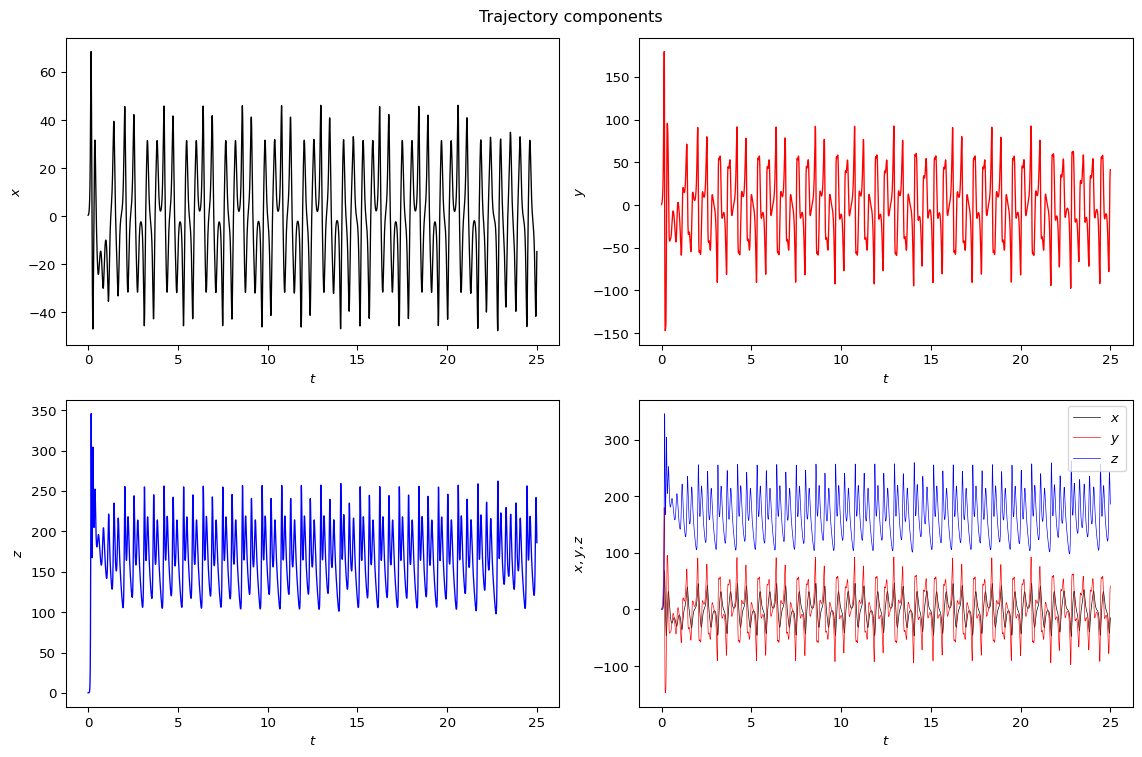

In [29]:
fig, axs = plt.subplots(2,2, figsize=(12,8), dpi = 96)
lim = 25000
axs[0,0].plot(t_eval[:lim], example_trajectory[:lim,0], lw = 1, c = 'k')
axs[0,0].set_xlabel(r'$t$')
axs[0,0].set_ylabel(r'$x$')
axs[0,1].plot(t_eval[:lim], example_trajectory[:lim,1], lw = 1, c = 'r')
axs[0,1].set_xlabel(r'$t$')
axs[0,1].set_ylabel(r'$y$')
axs[1,0].plot(t_eval[:lim], example_trajectory[:lim,2], lw = 1, c = 'b')
axs[1,0].set_xlabel(r'$t$')
axs[1,0].set_ylabel(r'$z$')

axs[1,1].plot(t_eval[:lim], example_trajectory[:lim,0], lw = 0.5, c = 'k', label = r'$x$')
axs[1,1].plot(t_eval[:lim], example_trajectory[:lim,1], lw = 0.5, c = 'r', label = r'$y$')
axs[1,1].plot(t_eval[:lim], example_trajectory[:lim,2], lw = 0.5, c = 'b', label = r'$z$')
axs[1,1].set_xlabel(r'$t$')
axs[1,1].set_ylabel(r'$x,y,z$')
plt.legend()
fig.suptitle('Trajectory components')
plt.tight_layout()
plt.savefig('../figs/lorenz_trajectory_comps.png', dpi = 150)
plt.show()

## Main quantities needed to test for chaos

1. **Cross-distance scaling.** The scaling of the long-term distance $ d_{12}(t \gg T_\lambda) $ of two trajectories,

$$
d_{12}(t \gg T_\lambda) \propto \delta^\nu, \quad d_{12}(t) = \langle |\mathbf{x}_1(t) - \mathbf{x}_2(t)| \rangle, \tag{2}
$$

may be used as a reliable indicator for chaos, where we denote $ d_{12}(t = 0) = \delta $ as the initial distance, and $ \nu $ as the cross-distance scaling exponent.

2. **Cross-correlation function.** An important point for real-world applications are the long-term repercussions of variations in the initial conditions. For concreteness, we consider:

$$
C_{12}(t) = \frac{\langle (x_1(t) - \mu) \cdot (x_2(t) - \mu) \rangle}{s^2}, \tag{3}
$$

the cross-correlation function of two bounded and initially close-by trajectories $ x_1(t) $ and $ x_2(t) $. Here, $ \langle ... \rangle $ denotes an average over initial conditions on the attractor sampled with the natural distribution, $ \mu $ the center of gravity, and $ s $ the average extent of the attracting set:

$$
\mu = \lim_{T \to \infty} \frac{1}{T} \int_T^{2T} x(t) \, dt, \quad 
s^2 = \lim_{T \to \infty} \frac{1}{T} \int_T^{2T} [x(t) - \mu]^2 \, dt. \tag{4}
$$

The cross-correlation is normalized to unity for close-by trajectories, i.e., for $ |x_1(t) - x_2(t)| \to 0 $. For chaotic attracting sets, the cross-correlation $ C_{12} $ vanishes in the long-term limit $ t \to \infty $, with a finite $ C_{12} \neq 0 $ implying finite amounts of predictability.

For a geometric comparison, we define the averaged square distance $ D_{12}(t) $ between two trajectories:

$$
D_{12}(t) = \langle [x_1(t) - x_2(t)]^2 \rangle,
$$

which leads, when using (3), to:

$$
D_{12}(t) = 2s^2 [1 - C_{12}(t)].
$$


3. **Lyapunov exponents.** The Lyapunov exponent $ \lambda $ quantifies the rate of separation of infinitesimally close trajectories in a dynamical system. It is defined as:

$$
\lambda = \lim_{t \to \infty} \lim_{\delta(0) \to 0} \frac{1}{t} \ln \frac{\delta(t)}{\delta(0)},
$$

where $ \delta(0) $ is the initial distance between two trajectories, and $ \delta(t) $ is the distance at time $ t $.

### Key Points:
- A positive Lyapunov exponent ($ \lambda > 0 $) indicates chaos, as it implies exponential divergence of nearby trajectories.
- A zero Lyapunov exponent ($ \lambda = 0 $) corresponds to neutral stability, as in periodic orbits.
- A negative Lyapunov exponent ($ \lambda < 0 $) indicates convergence, as trajectories tend to come closer over time. 



Below we test some of the implemented methods to calculate the Lyapunov exponent. these methods are either based on slope fitting of logarithmic distances or on the Benettin algorithm [2]. Lastly, I also implemented a way to look for the first k Lyapunov exponents, i.e. the spectrum.

The below test cases result in exponents similar to the ones from [1] for identical parametrization.

[2] Benettin, G., Galgani, L., Giorgilli, A. & Strelcyn, J.-M. Lyapunov characteristic exponents for smooth dynamical systems
and for hamiltonian systems; a method for computing all of them. part 1: Theory. Meccanica 15, 9–20 (1980).

In [32]:
def lorenz(x, t, sigma=10, rho=180.68, beta=8/3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return [dx, dy, dz]

initial_state = [1.0, 1.0, 1.0]

lambda_max, T_lambda = ly.log_slope(
    lambda x, t: mod.lorenz_system(x, t, r=180.68), initial_state, t_eval, std_tol=0.4
)
print(f"Largest Lyapunov Exponent (λ_max): {lambda_max}")
print(f"Lyapunov Prediction Time (T_λ): {T_lambda}")

Largest Lyapunov Exponent (λ_max): 1.6625887397436396
Lyapunov Prediction Time (T_λ): 6.924698327227603


In [10]:
sample_trajectory(example_trajectory, 200, 250, 500)

array([[ -3.73561884,   7.77954687, 150.10342933],
       [ -3.62164413,   7.65886409, 149.67532974],
       [ -3.62164413,   7.65886409, 149.67532974],
       ...,
       [ 44.95688168,  75.94503018, 229.61644597],
       [ 45.25362958,  73.59664548, 232.37361811],
       [ 45.25362958,  73.59664548, 232.37361811]])

In [170]:
# Example: Lorenz system
def lorenz(x, t, sigma=10, rho=180.68, beta=8/3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return [dx, dy, dz]


In [10]:
# Initial conditions and parameters
initial_state = [1.0, 1.0, 1.0]
T = 500  # Total time
dt = 0.001
Ttr = 200

# Compute Lyapunov exponent
lyapunov_exponent = ly().benettin(
    dynamics=lambda x, t: mod.lorenz_system(x, t, r = 180.68), 
    initial_state=initial_state, 
    T=T, dt=dt, Ttr=Ttr, show_progress=True
)
print(f"Maximum Lyapunov Exponent: {lyapunov_exponent}")


Lyapunov Exponent Calculation: 100%|█████████▉| 499.7469999950944/500 [00:43<00:00, 11.36it/s] /home/syntaxerror/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Lyapunov Exponent Calculation: 100%|██████████| 500.0019999950884/500 [00:43<00:00, 11.55it/s]

Maximum Lyapunov Exponent: 1.8244698404701476


In [4]:

# Initial conditions and parameters
initial_state = [1.0, 1.0, 1.0]
T = 500
dt = 0.001
Ttr = 200
N = 100000

# Compute the Lyapunov spectrum
lyapunov_exponents = ly().spectrum(
    mod.lorenz_vec2, mod.lorenz_jacobian, initial_state, N, k=3, dt=dt, Ttr=Ttr, show_progress=True
)
print(f"Lyapunov Spectrum: {lyapunov_exponents}")


Lyapunov spectrum: 100%|██████████| 100000/100000 [00:08<00:00, 11151.80it/s]

Lyapunov Spectrum: [  1.75419828   0.40030336 -15.55010839]


To analyze the cross correlation and the slope of the log of the cross-distance scaling, we generate sample trajectory for each $\rho$ control parameter value and then sample it with `sample_trajectory()` with a given `Ttr` transition time to assure we are on the attractor. 

With this samples, we basicaly obtain initial conditions from the attractor. Then we generate perturbed states with different $\delta_0$ distance parameter. We then evolve the system and check the cross-distance scaling and the cross-correlation respectively. The values of these together with the Lyapunov exponents will enable us to categorize the flow into **SC** (strong chaos), **PPC** (partially predictable chaos), **LF** (laminar flow) or **IND** (indefinite)

The next 3 cells demonstrate how the workflow is implemented for a single $\rho$ value.

In [2]:
# Parameters
delta_dist = 1e-4
dr = 0.003125
r_values = np.arange(180.6, 181.3, dr)

T = 500  # Total time
dt = 0.001
Ttr = 200
t_span = (0, 500)
t_eval = np.arange(t_span[0], t_span[1],dt)

T_sample = 500
n_samples = 100
delta_range = 10.0 ** np.arange(-9, -2.5, 1.5)
d_tol = 1e-3
T_multiplier = 10
T_max = 200

r_idx = 80

initial_states_ex = generate_pairs_of_initial_states(5, delta_dist)
trajectory_to_sample = sol = odeint(mod.lorenz_system, initial_states_ex[0][0], t_eval, args=(r_values[r_idx],))

# Sample trajectories
initial_conditions = sample_trajectory(trajectory_to_sample, Ttr=200, T_sample=T_sample, n_samples=n_samples)


The next figure shows the sampled trajectory for the chosen parametrization:

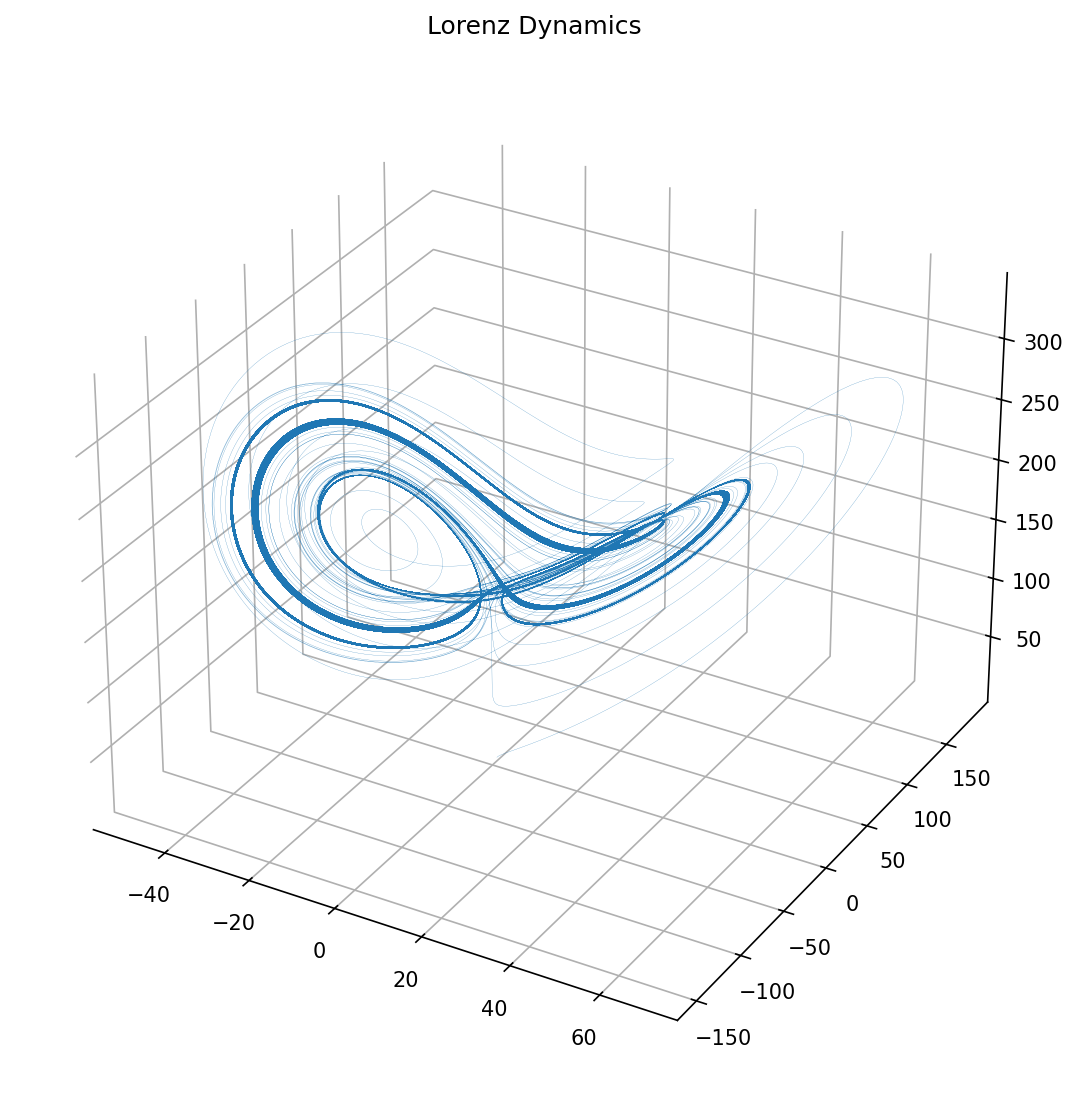

In [3]:
fig = plt.figure(figsize=(12, 9), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1,1,1,1))
ax.yaxis.set_pane_color((1,1,1,1))
ax.zaxis.set_pane_color((1,1,1,1))
ax.plot(trajectory_to_sample[:, 0], 
        trajectory_to_sample[:, 1], 
        trajectory_to_sample[:, 2],
        lw = 0.1)
plt.title("Lorenz Dynamics")
plt.show()


Testing for chaos for the given parametrization

In [4]:
###########
# Benettin algorithm - slower than log slope method
###########

# # Function to compute the Lyapunov exponent for a single initial condition
# def compute_lyapunov_exponent(initial_condition):
#     return ly.benettin(lambda x, t: mod.lorenz_system(x, t), initial_condition, T, dt=dt, Ttr=Ttr, show_progress=False)

# # Parallel computation
# lambd_maxes = []
# with ProcessPoolExecutor() as executor:
#     futures = {executor.submit(compute_lyapunov_exponent, ic): ic for ic in initial_conditions}
#     for future in tqdm(as_completed(futures), total=len(initial_conditions)):
#         try:
#             lambd_maxes.append(future.result())
#         except Exception as e:
#             print(f"Error computing Lyapunov exponent: {e}")

# # Compute the mean of the largest Lyapunov exponents
# lambd_max = np.mean(lambd_maxes)
# print(f"Largest Lyapunov Exponent: {lambd_max}")

# Extracting lambd_max from slope

def compute_lyapunov(initial_state):
    lambda_max, T_lambda = ly.log_slope(
        lambda x, t: mod.lorenz_system(x, t, r = r_values[r_idx]), initial_state, t_eval, std_tol=0.4
    )
    return lambda_max, T_lambda

# Parallel computation
results = []
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(compute_lyapunov, state): state for state in initial_conditions}
    for future in tqdm(as_completed(futures), total=len(initial_conditions)):
        try:
            results.append(future.result())
        except Exception as e:
            print(f"Error computing Lyapunov exponent: {e}")

# Post-process results
lambda_maxes = [result[0] for result in results if result]
T_lambdas = [result[1] for result in results if result]

# Compute the mean values
lambda_max_mean = np.mean(lambda_maxes)
T_lambda_mean = np.mean(T_lambdas)

print(f"Average Largest Lyapunov Exponent (λ_max): {lambda_max_mean}")
print(f"Average Lyapunov Prediction Time (T_λ): {T_lambda_mean}")

# Compute distances and correlations
distances, correlations = m().compute_distances_and_correlations_paral(
    mod.lorenz_system, initial_conditions, delta_range, T_max, d_tol, lambda_max_mean, r_values[r_idx], dt
)

# Compute distance slope
nu = m().compute_distance_slope(delta_range, distances)
C = np.mean(correlations)

# Classify the system
if nu > 0.5 and C > 0.5:
    chaos_type = "REG"  # Regular
elif nu <= 0.5 and C > 0.5:
    chaos_type = "PPC"  # Partially Predictable Chaos
elif nu <= 0.5 and C <= 0.5:
    chaos_type = "SC"  # Strongly Chaotic
else:
    chaos_type = "IND"  # Indeterminate

print(f"Chaos Type: {chaos_type}, nu: {nu}, C: {C}, r: {round(r_values[r_idx], 5)}")

100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Average Largest Lyapunov Exponent (λ_max): 0.08977512110275856
Average Lyapunov Prediction Time (T_λ): 800.2551265557331


Processing delta values: 100%|██████████| 5/5 [00:30<00:00,  6.07s/it]

Chaos Type: PPC, nu: 2.9375133429014368e-06, C: 0.9939292600830492, r: 180.85


Testing for chaos for various $\rho$ control parameter values:

In [2]:
lyaps = []
nus = []
correls = []
rs = []

delta_dist = 1e-4
dr = 0.003125
r_values = np.arange(180.6, 181.3, dr)

dt = 0.001
t_span = (0, 500)
t_eval = np.arange(t_span[0], t_span[1],dt)

Ttr = 200
T_max = 200
T_sample = 500
n_samples = 100
T_multiplier = 10

delta_range = 10.0 ** np.arange(-9, -2.5, 1.5)
d_tol = 1e-3

def compute_lyapunov(initial_state):
    lambda_max, T_lambda = ly.log_slope(
        lambda x, t: mod.lorenz_system(x, t, r = r), initial_state, t_eval, std_tol=0.4
    )
    return lambda_max, T_lambda


for r in tqdm(r_values, desc=r"r values "):
    initial_states_ex = generate_pairs_of_initial_states(5, delta_dist)
    trajectory_to_sample = sol = odeint(mod.lorenz_system, initial_states_ex[0][0], t_eval, args=(r,))
    initial_conditions = sample_trajectory(trajectory_to_sample, Ttr=Ttr, T_sample=T_sample, n_samples=n_samples)

    ###########
    # Extracting lambd_max from slope
    ###########

    # Parallel computation
    results = []
    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(compute_lyapunov, state): state for state in initial_conditions}
        for future in tqdm(as_completed(futures), total=len(initial_conditions)):
            try:
                results.append(future.result())
            except Exception as e:
                print(f"Error computing Lyapunov exponent: {e}")

    # Post-process results
    lambda_maxes = [result[0] for result in results if result]
    T_lambdas = [result[1] for result in results if result]

    # Compute the mean values
    lambda_max_mean = np.mean(lambda_maxes)
    T_lambda_mean = np.mean(T_lambdas)

    # Compute distances and correlations
    distances, correlations = m().compute_distances_and_correlations_paral(
        mod.lorenz_system, initial_conditions, delta_range, T_max, d_tol, lambda_max_mean, r, dt
    )

    # Compute distance slope
    nu = m().compute_distance_slope(delta_range, distances)
    C = np.mean(correlations)
    nus.append(nu)
    correls.append(C)
    lyaps.append(lambda_max_mean)
    rs.append(r)

    np.savetxt('../outputs/lorenz_c_nu_lyap.dat', np.vstack((rs, lyaps, nus, correls)).T)

r values :   0%|          | 0/225 [00:00<?, ?it/s]

r values : 100%|██████████| 225/225 [3:05:26<00:00, 49.45s/it]


Plotting the last three subplots from Fig 1. of [1] with my own results:

In [15]:
data.shape[1]

4

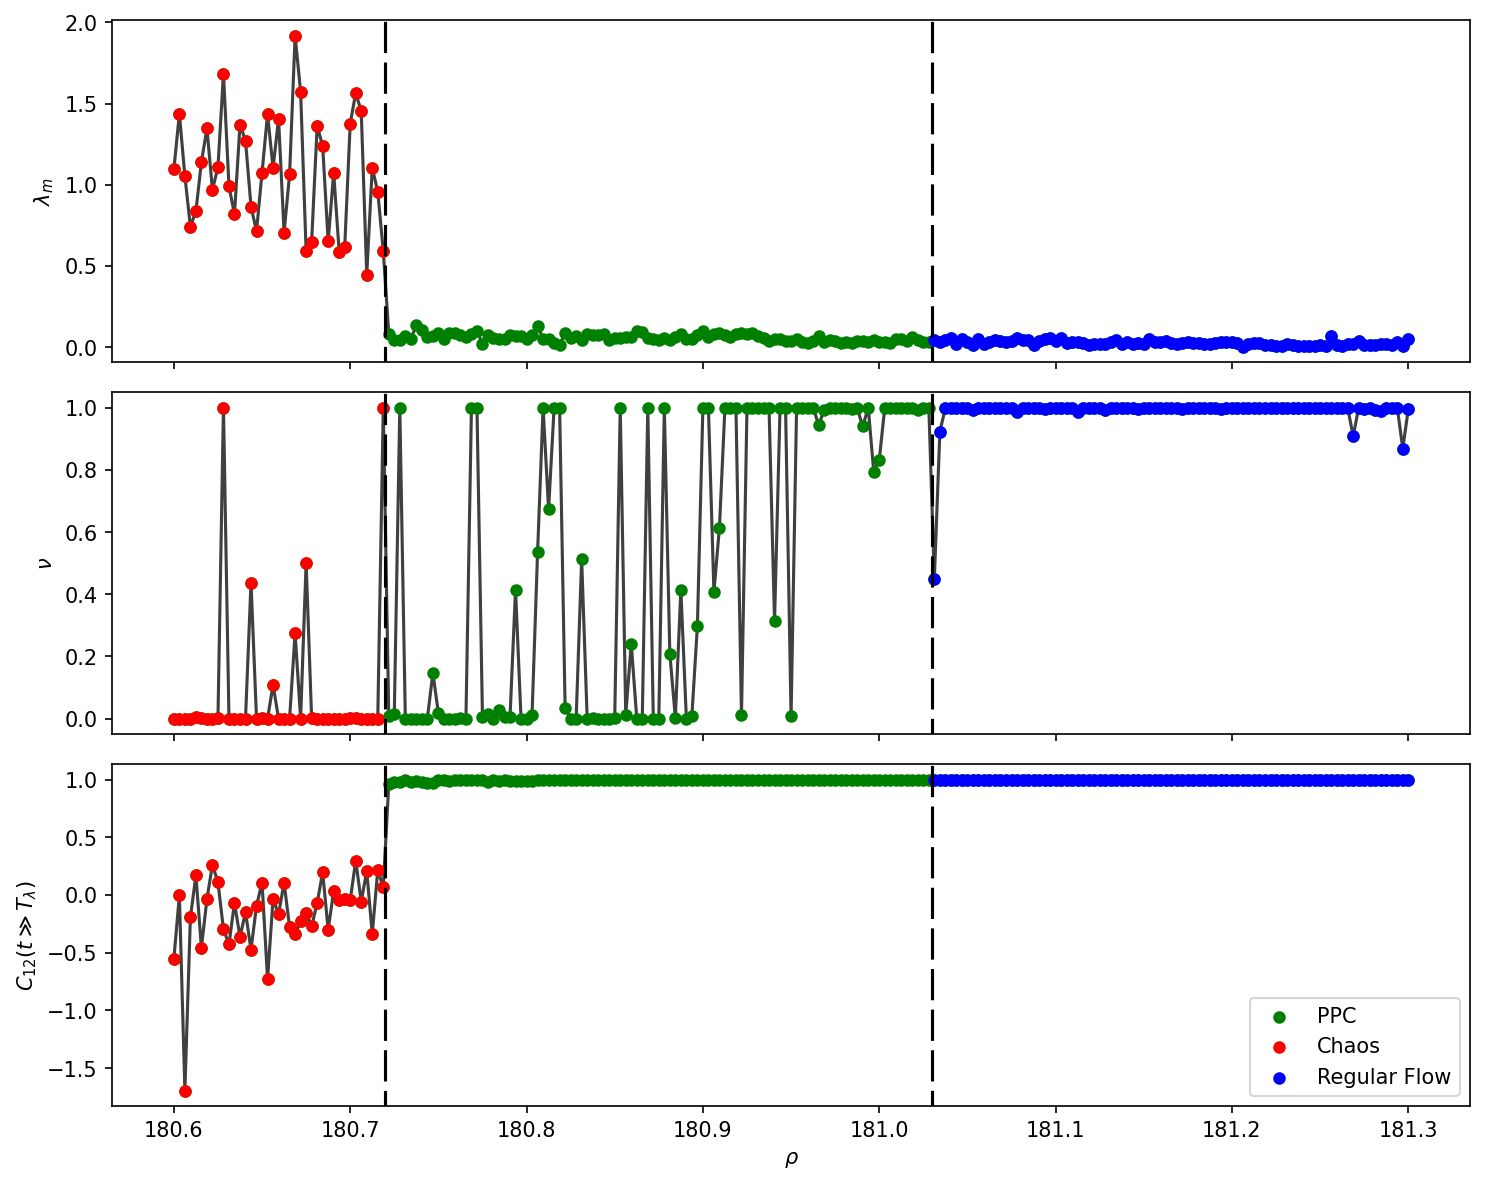

In [28]:
fig, ax = plt.subplots(3, figsize = (10,8), sharex=True, dpi=150)
ax = ax.flatten()

load_sim = 1
if load_sim:
    data = np.loadtxt('../outputs/lorenz_c_nu_lyap.dat')

mask1 = data[:,0] <= 180.72
mask2 = data[:,0] >= 181.03
labels = [r'$\lambda_m$', r'$\nu$', r'$C_{12}(t\gg T_\lambda)$']

colors = ['r', 'g', 'lime', 'b']

for i in range(data.shape[1]-1):

    ax[i].plot(data[:,0], data[:, i+1], lw = 1.5, c = 'k', alpha = .75, zorder = 0)
    ax[i].set_ylabel(rf"{labels[i]}")

    ax[i].scatter(data[:,0], data[:, i+1], color='green', s=25, label='PPC')
    ax[i].scatter(data[mask1,0], data[mask1, i+1], color='red', s=25, label='Chaos')
    ax[i].scatter(data[mask2,0], data[mask2, i+1], color='blue', s=25, label='Regular Flow')
    
    ax[i].axvline(x=181.03, color='k', ls = (5, (10, 3)))
    ax[i].axvline(x=180.72, color='k', ls = (5, (10, 3)))

ax[i].set_xlabel(r"$\rho$")
plt.tight_layout()
plt.legend()
plt.savefig("../figs/lyap_nu_C.png", dpi = 150)
plt.show()

# Conclusions

In this study, I employed the Lyapunov exponent, cross-distance and cross-correlation to assess the stability and predictability of chaotic systems. With this I successfully reproduced the main figures from the basis article, [1]. I also realised a python implementation for Lyapunov ecponent calculation with different approaches (slope, Benettin, spectrum) and implemented a 0-1 test for chaos prediction based on timeseries, following the results of [1]

By comparing the Lyapunov exponents for different $\rho$ values, we observed that the Lyapunov exponents decrease with increasing $\rho$, indicating a more chaotic behavior.

Moreover, we found similar behavior regarding the exponent $\nu$ of the cross distance correlation and the value of $C_{12}$. With approaching the laminar flow region their values increase and tend to approach $1$, where in the LF region it reaches the value of $1$.

Investigating the values of $\lambda_m$, $\nu$ and $C_{12}$ in function of the control parameter $\rho$ enables to predict the different types of the flow (SC, PPC or LF).

Of couyrse the range of $\delta_0$, transient times, used numerical integrators and time resolution all play a key role in the successful prediction of the flow type. Here I used `scipy.integrate.odeint` method, that uses FORTRAN `lsoda` package. I also implemented other methods (cf. `src/solvers.py`). The timestep was consistently kept at `dt=0.001`, `dr=0.003125`, `T_max=500` and `Ttr=200` in accordance with [1]. Due to the integrator differences and numerical error propagation in `python` and `julia` the results' values are not matching 100%, but they do yield the same flow regiens and predict the same behavior.

This method can be used in arbitrary dimension and for arbitrary system and takes considerably less time and memory than storing the different trajectories for the different parametrisation and then performing an analysis.